In [9]:
import esm
import pandas as pd
import torch

In [10]:
model, alphabet = esm.pretrained.esm1b_t33_650M_UR50S()

if torch.cuda.is_available():
    model = model.cuda()
    print("Modell auf GPU geladen.")
model.eval()  # Set the model to evaluation mode
print(model)

ProteinBertModel(
  (embed_tokens): Embedding(33, 1280, padding_idx=1)
  (layers): ModuleList(
    (0-32): 33 x TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
      )
      (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=1280, out_features=5120, bias=True)
      (fc2): Linear(in_features=5120, out_features=1280, bias=True)
      (final_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    )
  )
  (contact_head): ContactPredictionHead(
    (regression): Linear(in_features=660, out_features=1, bias=True)
    (activation): Sigmoid()
  )
  (embed_positions): LearnedPositionalEmbedding(1026, 1280, padding_idx=1)


### Create Dataset

In [11]:
print(len(alphabet.all_toks[4:25]))
amino_acids = alphabet.all_toks[4:24]
amino_acids_df = pd.DataFrame(amino_acids, columns=["Amino Acid"])
amino_acids_df["property"] = ""
amino_acids_df.set_index("Amino Acid", inplace=True)
amino_acids_df.loc[[ "V", "L", "I", "M","A"], "property"] = "hydrophobic"
amino_acids_df.loc[[ "F", "W", "Y"], "property"] = "aromatic"
amino_acids_df.loc[[ "Q","N","S","T"], "property"] = "polar"
amino_acids_df.loc[[ "C","G","P"], "property"] = "unique"
amino_acids_df.loc[[ "D","E"], "property"] = "negatively charged"
amino_acids_df.loc[[ "K","R", "H"], "property"] = "positively charged"
amino_acids_df.reset_index(inplace=True)
amino_acids_df


amino_acids_df

21


,Amino Acid,property
0,L,hydrophobic
1,A,hydrophobic
2,G,unique
3,V,hydrophobic
4,S,polar
5,E,negatively charged
6,R,positively charged
7,T,polar
8,I,hydrophobic
9,D,negatively charged


### with \<cls\> token

In [12]:
batch_converter = alphabet.get_batch_converter()
data = [(aa, aa) for aa in amino_acids]
batch_labels, batch_strs, batch_tokens = batch_converter(data)

if torch.cuda.is_available():
    batch_tokens = batch_tokens.to(device="cuda")

with torch.no_grad():
    representations = model(batch_tokens, repr_layers=[model.num_layers], return_contacts=False)['representations'][model.num_layers]
representations = representations.detach()

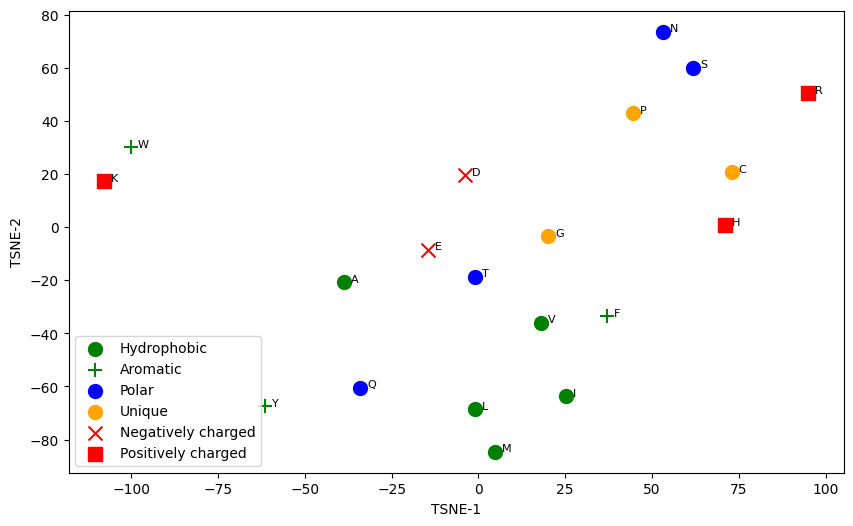

In [13]:
import helpers.helper as helper
#plot cls token
emb = representations[:,0,:].cpu().numpy()
helper.plot_tsne_exp1(amino_acids_df, emb)

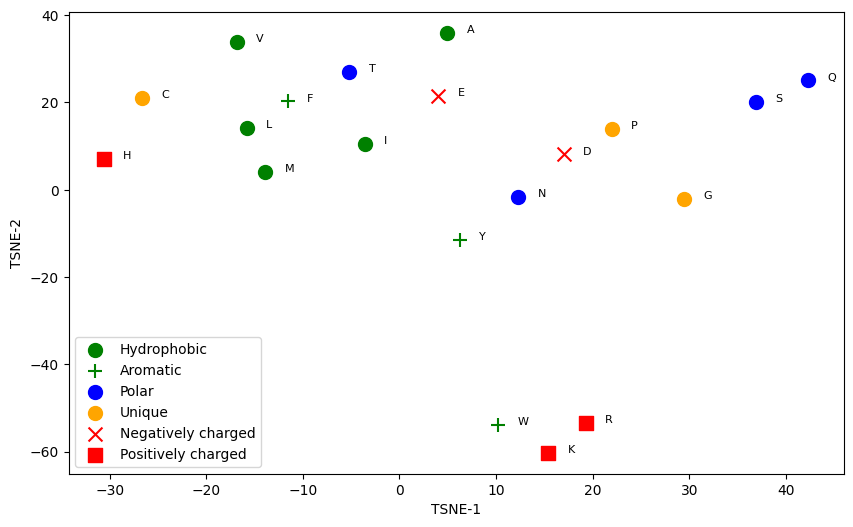

In [14]:
#plot amino token
emb = representations[:,1,:].cpu().numpy()
helper.plot_tsne_exp1(amino_acids_df, emb)

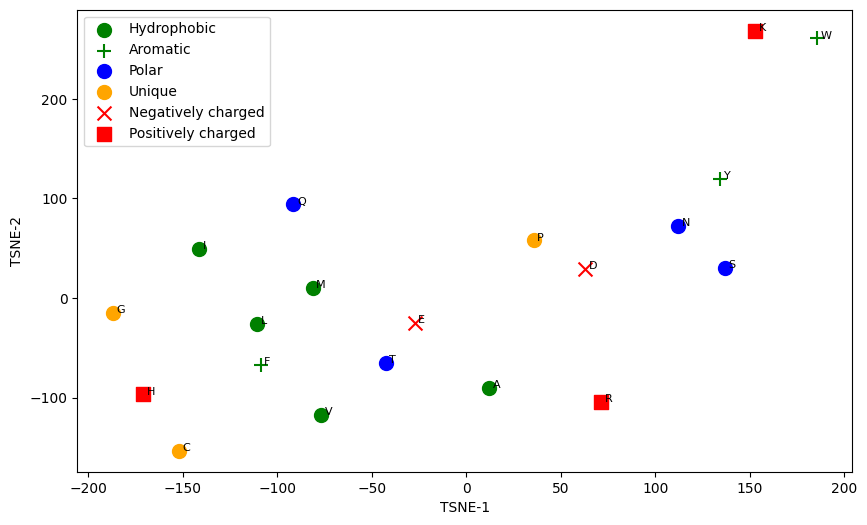

In [15]:
#plot whole weight matrix
emb = representations.cpu().numpy().reshape(20, -1)
helper.plot_tsne_exp1(amino_acids_df, emb)

### without \<cls\> token


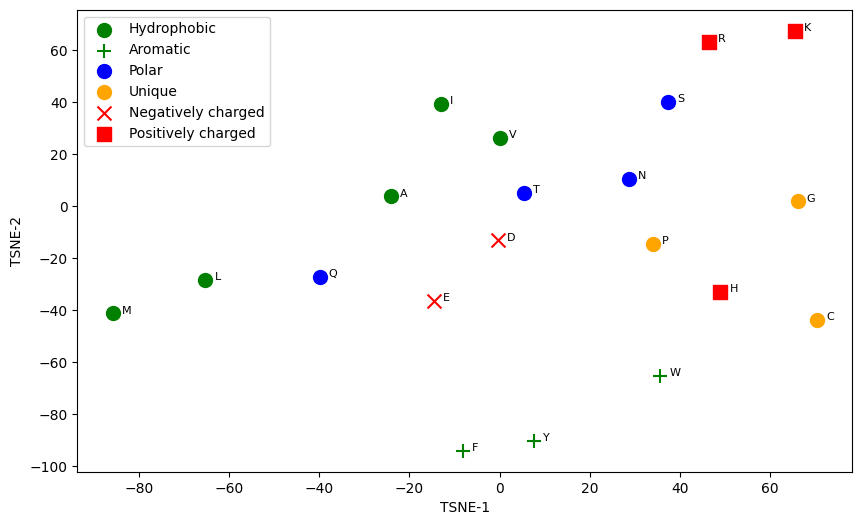

In [16]:
#plot amino token
data = [(aa, aa) for aa in amino_acids]
batch_tokens = torch.tensor([alphabet.encode(aa) for aa in amino_acids])

if torch.cuda.is_available():
    batch_tokens = batch_tokens.to(device="cuda")

with torch.no_grad():
    representations = model(batch_tokens, repr_layers=[model.num_layers], return_contacts=False)['representations'][model.num_layers]
representations = representations.detach()

representations.squeeze_(1)

emb = representations.cpu().numpy().reshape(20, -1)
helper.plot_tsne_exp1(amino_acids_df, emb)